# Transfer Learning for Computer Vision

In this notebook we use Transfer Learning for a Computer Vision task.

We will use a problem of identifying ants and bees in images. We will use the [ResNet18](https://arxiv.org/abs/1512.03385) pretrained network ([PyTorch implementation](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html)), specifically the weights for the imagenet-1k dataset.

There are two major transfer learning scenarios (see notes [here](https://cs231n.github.io/transfer-learning/)):

- **Finetuning the ConvNet:** Instead of random initialization, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.
- **ConvNet as fixed feature extractor:** Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.

*Following the official tutorial: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html*

## Installation

Imports:

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import math
import time
import os
from pathlib import Path
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True  # https://discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936/7

GPU setup if possible:

In [2]:
# set up device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
if device.type == 'cuda':
    print(f'using: {torch.cuda.get_device_name(0) if device.type == "cuda" else f"CPU with cores available: {os.cpu_count()}"}')

using: NVIDIA GeForce MX350


## Data

This dataset is a very small subset of imagenet. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

Download data [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip) or [here](https://www.kaggle.com/datasets/thedatasith/hymenoptera) and extract to the `data/` directory, so that the file structure looks like:

```
+-- transferlearningforCV.ipynb
+-- data/
|   +-- hymenoptera_data/
|   |   +-- train/
|   |   |   +-- ants/
|   |   |   +-- bees/
|   |   +-- val/
|   |   |   +-- ants/
|   |   |   +-- bees/
```

Where the final sub-folders `ants/` and `bees/` contain images of the ants and bees respectively. In the following, we create a dataset class for us to work with. In this, we collect the data found at `data_dir`, collecting the data from `val/` if `validation=True` and from `train/` otherwise. We perform a number of transforms on it as data augmentation, such as:

- Random Resizing and Cropping to `crop_size` (for training only)
- Randomly horizontally flipping the image (for training only)
- Resizing to the nearest power of 2 from `crop_size`, rounding up (for validation only)
- Cropping from center to `crop_size` (for validation only)
- Converting to a tensor
- Applying normalization, this is typical for these types of images as it removes the bias our eyes have on certain wavelengths

We then define a `classes` variable which will be a list containing our labels (in this case: `['ants', 'bees']`).

In [3]:
class HymenopteraDataset(object):
    def __init__(self, data_dir, crop_size=224, validation=False):
        self.crop_size = crop_size
        self.validation = validation
        self.folder = Path(data_dir + '/train') if not self.validation else Path(data_dir + '/val')

        # create transforms for each
        data_transforms = {
            'train': torchvision.transforms.Compose([
                torchvision.transforms.RandomResizedCrop(self.crop_size),
                torchvision.transforms.RandomHorizontalFlip(),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'val': torchvision.transforms.Compose([
                torchvision.transforms.Resize(2**(math.ceil(math.log(self.crop_size, 2)))),
                torchvision.transforms.CenterCrop(self.crop_size),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
        }

        # create from imagefolder
        self.dataset = torchvision.datasets.ImageFolder(self.folder, data_transforms['val' if self.validation else 'train'])
        self.classes = self.dataset.classes
        
    def __getitem__(self, index):
        return self.dataset[index]

    def __len__(self):
        return len(self.dataset)

Let's get our training and validation data, cropping to a size of `224`. Then we will show some examples from this dataset (remember we normalized the colors in the image). We also then convert these datasets to dataloaders, allowing us to easily pass in data when training:

*Note that you may have to reduce the number of workers if the dataloader doesn't work as expected. I believe there is a problem with using GPU memory on Jupyter.*

In [4]:
# import datasets and display examples
image_datasets = {x: HymenopteraDataset("data/hymenoptera_data/", 224, False if x == 'train' else True) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(f"Training set size: {dataset_sizes['train']} images")
print(f"Validation set size: {dataset_sizes['val']} images")

# create dataloader
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=0) for x in ['train', 'val']}

Training set size: 244 images
Validation set size: 153 images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4110641].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.2489083].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.535425].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.465708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.980906..2.2739873].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0007002..2.64].

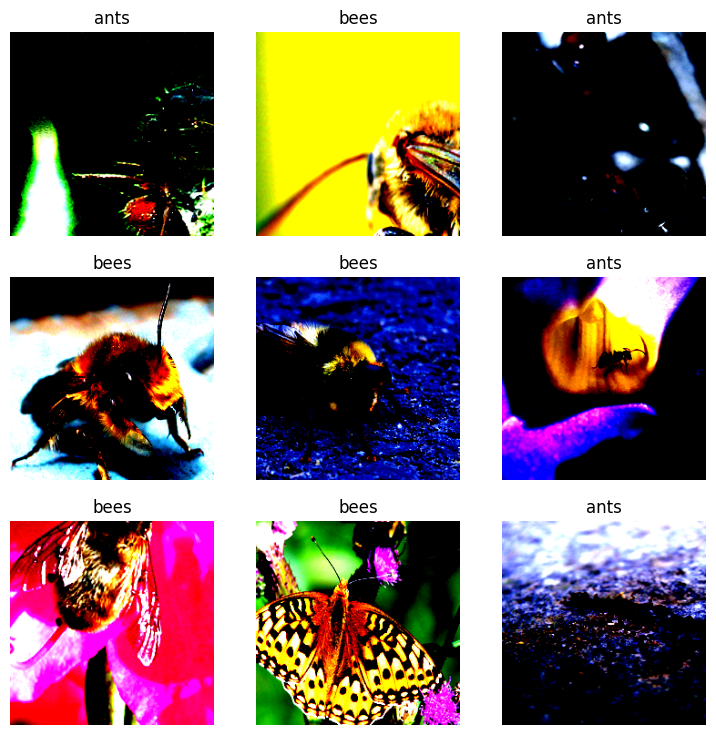

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 9))

for y in range(3):
    for x in range(3):
        sample_idx = torch.randint(len(image_datasets['train']), size=(1,)).item()
        img, label = image_datasets['train'][sample_idx]
        axes[y, x].imshow(img.numpy().transpose(1,2,0))
        axes[y, x].set_axis_off()
        axes[y, x].set_title(class_names[label])
plt.show()

## Training via finetuning

Let's now create a function to train our model. For this, we require the dataloaders, size of the datasets used, what device we are using, the pretrained model, our criterion (loss) and optimizer, our learning rate scheduler, and the number of epochs for training. All these will be defined later (if not done so already). We track how long the training takes, along with tracking the best performing model so far, saving its weights in a temporary directory before we load it and return it at the end of training. In every epoch we have two "phases" - training and validation. In the training phase, we train the model using our training data, allowing the model to update, along with stepping through our LR scheduler. In the validation phase, we only allow the model to evaluate on the respective data, using the accuracy metric obtained to decide if the model is our best model seen so far.

In [6]:
def train_model(dataloaders, dataset_sizes, device, model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    # create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        # save first checkpoint
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)

        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch + 1}/{num_epochs}')
            print('-' * 10)

            # each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # set model to training mode
                else:
                    model.eval()   # set model to evaluate mode

                running_loss = 0.0
                running_correct = 0

                # iterate over data
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # stats
                    running_loss += loss.item() * inputs.size(0)
                    running_correct += torch.sum(preds == labels.data)
                # step scheduler for LR
                if phase == 'train':
                    scheduler.step()

                # get stats for this epoch
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_correct.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # save checkpoint
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        # finished, display stats
        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))

    return model

The following is a helper function for displaying images from a tensor, accounting for the normalization done previously:

In [7]:
def imshow(input, title=None):
    '''
    Displays image from tensor.
    '''
    input = input.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    plt.imshow(input)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In the following we now visualise the model. This involves evaluating the model on the validation data, displaying the image and the models predicted classification as the title. All images are displayed in a grid of 2 columns and expanding number of rows.

In [8]:
def visualize_model(dataloaders, class_names, model, num_images=6):
    '''
    Tests model on num_images images and visualizes using the custom imshow() function.
    '''
    was_training = model.training  # will set model back to train mode if it was training before visualization
    model.eval()  # evaluation mode
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        # get predictions for everything in validation set an display them using above imshow() function
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[predicted[j]]}')
                imshow(inputs.cpu().data[j])

                # set model to previous state
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        # set model to previous state
        model.train(mode=was_training)
    plt.show()

Lets now finally get our pretrained model that we will finetune. Note that we set the final fully connected layer to instead output our desired number of classes:

In [9]:
model_ft = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))  # create new classification layer for our desired output
model_ft = model_ft.to(device)
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Now defining our loss, optimizer, and learning rate scheduler. Notice that we have a very small learning rate even to begin, since we are finetuning a pretrained model:

In [10]:
criterion = nn.CrossEntropyLoss()

# all parameters of the model are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Now finally the training part, we will then visualise the models predictions after trainnig for 25 epochs, using an NVidia GeForce MX350 training took about 5 minutes:

In [11]:
model_ft = train_model(dataloaders, dataset_sizes, device, model_ft, criterion, optimizer_ft, exp_lr_scheduler, 25)

Epoch 1/25
----------
train Loss: 0.5857 Acc: 0.7172
val Loss: 0.2290 Acc: 0.8889

Epoch 2/25
----------
train Loss: 0.5169 Acc: 0.7992
val Loss: 0.2542 Acc: 0.9020

Epoch 3/25
----------
train Loss: 0.5120 Acc: 0.7705
val Loss: 0.1783 Acc: 0.9346

Epoch 4/25
----------
train Loss: 0.4951 Acc: 0.7910
val Loss: 0.3639 Acc: 0.8497

Epoch 5/25
----------
train Loss: 0.4027 Acc: 0.8361
val Loss: 0.2211 Acc: 0.9085

Epoch 6/25
----------
train Loss: 0.5394 Acc: 0.8156
val Loss: 0.2997 Acc: 0.9150

Epoch 7/25
----------
train Loss: 0.4221 Acc: 0.8607
val Loss: 0.2211 Acc: 0.9085

Epoch 8/25
----------
train Loss: 0.3928 Acc: 0.8320
val Loss: 0.2350 Acc: 0.9085

Epoch 9/25
----------
train Loss: 0.3961 Acc: 0.8156
val Loss: 0.2344 Acc: 0.8954

Epoch 10/25
----------
train Loss: 0.2897 Acc: 0.8648
val Loss: 0.2223 Acc: 0.9020

Epoch 11/25
----------
train Loss: 0.3309 Acc: 0.8607
val Loss: 0.2149 Acc: 0.9020

Epoch 12/25
----------
train Loss: 0.3211 Acc: 0.8607
val Loss: 0.2274 Acc: 0.9085

E

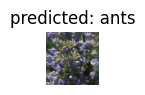

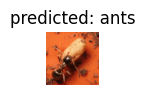

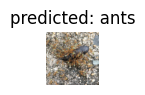

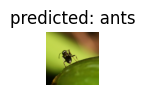

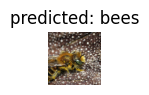

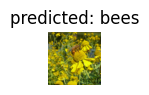

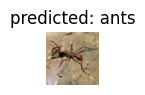

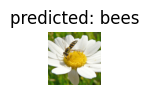

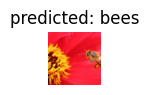

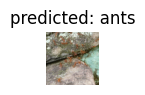

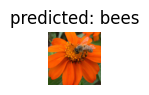

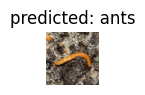

In [12]:
visualize_model(dataloaders, class_names, model_ft, 6)

## Training as a fixed feature extractor

Here, we need to freeze all the network except the final layer. We need to set ``requires_grad=False`` to freeze the parameters so that the gradients are not computed in `backward()`. Everything else is as before:

In [13]:
# sert all parameters in model to have no grad
model_conv = torchvision.models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
for param in model_conv.parameters():
    param.requires_grad = False

# parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# only parameters of final layer are being optimized
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [14]:
model_conv = train_model(dataloaders, dataset_sizes, device, model_conv, criterion, optimizer_conv, exp_lr_scheduler, 25)

Epoch 1/25
----------
train Loss: 0.7858 Acc: 0.6025
val Loss: 0.3233 Acc: 0.8562

Epoch 2/25
----------
train Loss: 0.3899 Acc: 0.8279
val Loss: 0.1898 Acc: 0.9477

Epoch 3/25
----------
train Loss: 0.5906 Acc: 0.7295
val Loss: 0.1756 Acc: 0.9477

Epoch 4/25
----------
train Loss: 0.5885 Acc: 0.7254
val Loss: 0.4283 Acc: 0.8497

Epoch 5/25
----------
train Loss: 0.4824 Acc: 0.7951
val Loss: 0.3566 Acc: 0.8562

Epoch 6/25
----------
train Loss: 0.5081 Acc: 0.8074
val Loss: 0.1691 Acc: 0.9346

Epoch 7/25
----------
train Loss: 0.5251 Acc: 0.7910
val Loss: 0.1654 Acc: 0.9542

Epoch 8/25
----------
train Loss: 0.2750 Acc: 0.8648
val Loss: 0.1701 Acc: 0.9542

Epoch 9/25
----------
train Loss: 0.3156 Acc: 0.8648
val Loss: 0.1872 Acc: 0.9477

Epoch 10/25
----------
train Loss: 0.3398 Acc: 0.8525
val Loss: 0.1702 Acc: 0.9542

Epoch 11/25
----------
train Loss: 0.4663 Acc: 0.7705
val Loss: 0.1669 Acc: 0.9477

Epoch 12/25
----------
train Loss: 0.3975 Acc: 0.8197
val Loss: 0.1680 Acc: 0.9542

E

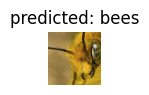

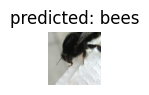

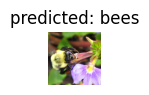

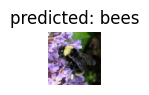

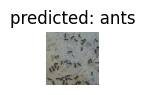

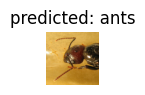

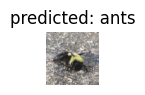

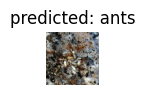

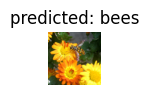

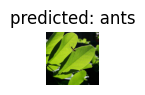

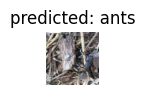

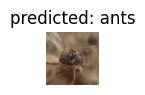

In [15]:
visualize_model(dataloaders, class_names, model_conv, 6)